# Coordinate Descent with Lasso Regression

John James      
Net Id: 662596998

## Lasso Penalized Regression

Lasso penalized regression is a model selection technique, often used when the number of predictors $p$ exceeds the number of observations $n$. By suppressing the magnitudes of irrelevant predictors to zero, lasso enforces sparsity, effectively reducing the number of predictors.

Let $y_i$ be the target for the $i^{th}$ observation, $x_{i,j}$ be the $j^{th}$ feature from the $i^{th}$ observation and $\beta_j$ be the coefficient corresponding to  $x_{i,j}$ . Ignoring the intercept $\beta_0$, the lasso penalized regression can be expressed as minimizing the following objective function:

$$\underset{\beta_j}{min}\displaystyle\sum_{i=1}^n (y_i-\displaystyle\sum_{k\ne j} x_{ik}\hat{\beta_k}-x_{ij}\beta_j)^2+\lambda\displaystyle\sum_{k \ne j}|\hat{\beta_k}|+\lambda|\beta_j|,$$

where we seek to find a $\hat{\beta_j}\approx\beta_j\forall j\in\{1..p\}$ and $\beta_j$ is the unknown true model parameter. Since we are minimizing with respect to $\beta_j$, we can ignore the $\lambda\displaystyle\sum_{k \ne j}|\hat{\beta_k}|$ express. Further, we can let:

$$r_i = y_i-\displaystyle\sum_{k\ne j} x_{ik}\hat{\beta_k}.$$

Now the objective function minimizes to:

$$\underset{\beta_j}{min}\displaystyle\sum_{i=1}^n(r_i-x_{ij}\beta_j)^2+\lambda|\beta_j|.$$

## Coordinate Descent

The basic coordinate descent (CD) framework updates and adjusts a single parameter while holding all other parameters fixed and repeats until a termination condition is met. More precisely:

### Coordinate Descent Algorithm

1. Set $k$ = 0
2. repeat
   1. Select an index $i_k\in \{1,2,...,n\};
   2. Update x_i_k to x^k_i_k b depending upon x^{k-1};
   3. Keep x_j unchanged, i.e., x_j^k=x_j^{k-1}, $\forall j\ne k$;
   4. Let $k=k+1$
3. until termination condition is satisfied.

Intuitively, CD methods can be visualized (in the 2 dimensional case) as a moving along a grid, one component per iteration, down the contours of the objective function.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Data
For this exercise we will use the Boston housing data, courtesy of Harrison, D. and Rubinfeld, D.L. `Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. 

In [2]:
filename = "../data/raw/data.csv"
boston = pd.read_csv(filename)
X = boston
X = X.drop(columns=["Y"])
y = boston.iloc[:,13].to_numpy().reshape(-1,1)
var_names = X.columns

## Lasso via Coordinate Descent

In [4]:
def MyLasso(X, y, lam_seq, maxit = 500):
    
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam_seq: sequence of lambda values 
    # maxit: number of updates for each lambda 
 
    # Center/Scale X
    scaler = preprocessing.StandardScaler()
    Xs = scaler.fit_transform(X)    # X standardized to 0 mean and unit variance

    # Center y
    yc = y - np.mean(y) # y centered
  
    n, p = Xs.shape
    nlam = len(lam_seq)
    
    ##############################
    # YOUR CODE: 
    # Record the corresponding means and scales
    # For example, 
    # y_mean = mean of y
    # Xs = centered and scaled X
    ##############################
    y_mean = np.mean(y)
    X_mean = np.mean(X, axis=0)
    X_scale = scaler.scale_
    X_std = np.std(X)
    

    

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = yc
    B = np.zeros((nlam, p + 1))
    
    # Triple nested loop
    for m in range(nlam):
        lam = 2 * n * lam_seq[m]
        for step in range(maxit):
            for j in range(p):
                Xs_j = Xs[:, j].reshape(-1,1)
                r = r + Xs_j * b[j]
                b[j] = one_var_lasso(r, Xs_j, lam)
                r = r - Xs_j * b[j]
        B[m, 1:] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 1]
    ##############################
    coef = B[:,1:]/X_scale
    icept = (y_mean - coef.dot(X_mean)).reshape(-1,1)
    B = np.concatenate((icept, coef), axis=1)
    
    return(B.T)

### Single Variable Lasso Estimate
Here, we obtain the Lasso estimate for $\beta_j$ while keeping the other coefficients fixed.

In [5]:
def one_var_lasso(r, x, lam):
    # the code is written with r, x being n-by-1 vectors
    xx = x.T @ x
    xr = x.T @ r
    b = (abs(xr) - lam/2)/xx
    if b < 0:
        b = 0
    b = np.sign(xr) * b
    return(b)

- We scale the lambda value by (2n) in lam = 2*n*lam.seq[m] so that we may evaluate our results with GLMNet which uses the following objective function:
$\frac{1}{2n} $RSS+λ|β| ∝ RSS+2nλ|⋅β|
 

## Unit Test
Target coefficient values for unit testing are provided below.

In [3]:
filename = "../models/coefs.csv"
lasso_coef = pd.read_csv(filename)
lasso_coef.shape

(14, 80)

In [6]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

In [7]:
myout.shape
log_lam_seq.shape, lam_seq.shape

((80,), (80,))

## Visualization
Here, we provide a visualization of the path for each of the non-intercept coefficients. This path plot shows the lambda values on the log scale, and the values of the coefficients on the y axis.

(-8.35, -0.6499999999999999, -0.30999458351283665, 0.4997421988480716)

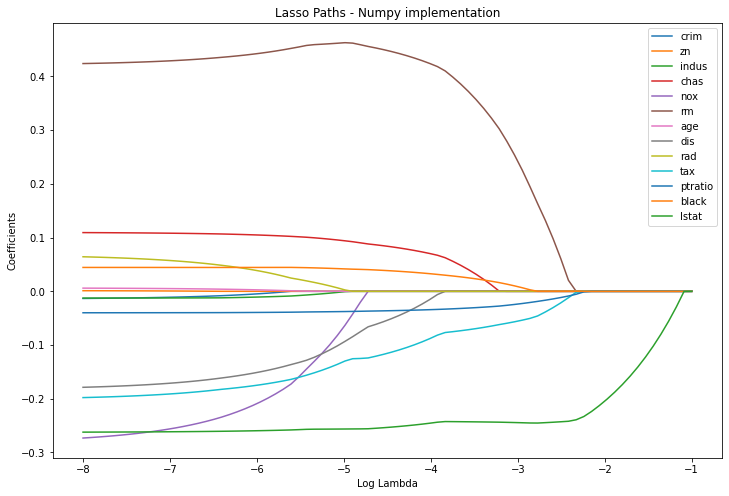

In [8]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

## Accuracy
Below, we have the overall accuracy of coordinate descent parameter estimation.

In [9]:
abs(myout - lasso_coef).max(axis=0).max()

0.004645317416215988